# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
def get_files():
    return ("/home/carnd/data/train.p", 
            "/home/carnd/data/test.p")
def get_csv_file():
    return "/home/carnd/git/CarND-Traffic-Sign-Classifier-Project/signnames.csv" 


In [2]:
import cv2

def rgb2gray(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_RGB2GRAY)
    return func_wrapper

def gray2rgb(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_GRAY2RGB)
    return func_wrapper

def gray2equalizeHist(func):
    def func_wrapper(*args, **kwargs):
        return cv2.equalizeHist(func(*args, **kwargs))
    return func_wrapper
        
def rgb2hsv(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_RGB2HSV)
    return func_wrapper

def hsv2rgb(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_HSV2RGB)
    return func_wrapper

def hsv2equalizeHist(func):
    def func_wrapper(*args, **kwargs):
        h,s,v = cv2.split(func(*args, **kwargs))
        v = cv2.equalizeHist(v)
        return cv2.merge((h,s,v))
    return func_wrapper

def rgb2normalize(func):
    def func_wrapper(*args, **kwargs):
        r,g,b = cv2.split(func(*args, **kwargs))
        x = r.copy()
        r = cv2.normalize(r,x)
        g = cv2.normalize(g,x)
        b = cv2.normalize(b,x)        
        return cv2.merge((r,g,b))
    return func_wrapper    
def no_image(image):
    return image

                
@rgb2normalize
def norm_image(image):
    return image

@gray2rgb
@gray2equalizeHist
@rgb2gray
def gray_image(image):
    return image

@hsv2rgb
@hsv2equalizeHist
@rgb2hsv
def image2(image):
    return image

def convert_images(images):
    X = [ no_image(features) for features in images]
    Y = X
    #Y = np.array(X)[:,:,:,:-2]
    return Y


In [3]:
# Load pickled data
import pickle
import numpy as np 
from sklearn.cross_validation import train_test_split
# TODO: Fill this in based on where you saved the training and testing data

training_file, testing_file = get_files()

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

train['features'] = convert_images(train['features'])
test['features'] = convert_images(test['features'])

X_train, X_validation, y_train, y_validation = train_test_split(train['features'], train['labels'], test_size=0.20, random_state=42)
X_test, y_test = test['features'], test['labels']



/home/carnd/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
print(len(X_train[0]))
print(len(X_train[0][0]))
print(len(X_train[0][0][0]))

32
32
3


In [5]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = [len(X_train[0]),len(X_train[0][0]),len(X_train[0][0][0])]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 31367
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [6]:
import csv
with open(get_csv_file(), 'rt') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    signname = [ row['SignName'] for row in spamreader]
print(signname)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


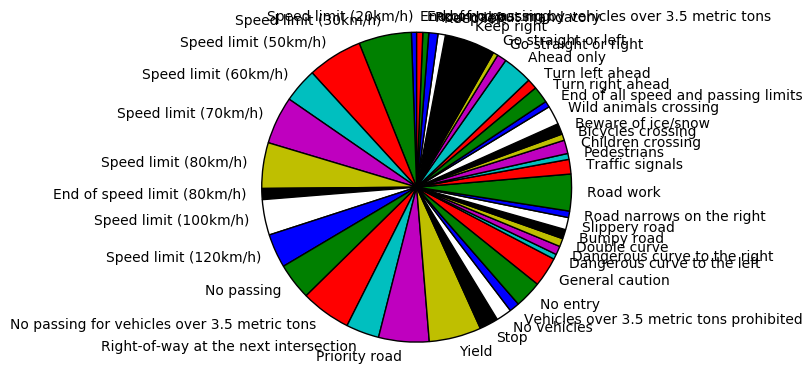

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

foo = np.unique(y_train,return_counts=True)
count = foo[1]
plt.pie(count, labels=signname,shadow=False,startangle=90,radius=5.25)
plt.axis('equal')

#y_pos = np.arange(len(y_train))
#performance = 3 + 10 * np.random.rand(len(y_train))
#error = np.random.rand(len(y_train))

#plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
#plt.yticks(y_pos, y_train)
#plt.xlabel('Performance')
#plt.title('How fast do you want to go today?')

plt.show()

In [8]:
# Plot the first occurence of each sign
#for i in range(len(signname)):
#    a = np.where(y_train==i)[0][0]
#    plt.suptitle(signname[i], fontsize=14, fontweight='bold')
#    plt.imshow(cv2.split(X_train[a]))
#    plt.show()

In [9]:
import cv2
#for i in range(len(signname)):
#    a = np.where(y_train==i)[0][0]
#    foo =cv2.cvtColor(X_train[a], cv2.COLOR_RGB2HSV)
#    h,s,v = cv2.split(foo)
#    v = cv2.equalizeHist(v)
#    img = cv2.merge((h,s,v))
#    img =cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
#    plt.suptitle(signname[i], fontsize=14, fontweight='bold')
#    plt.imshow(img)#,  cmap="Greys_r")
#    plt.show()
##for i in range(len(signname)):
##    a = np.where(y_train==i)[0][0]
##    img = image2(X_train[a])
##    #print(img)
##    plt.suptitle(signname[i], fontsize=14, fontweight='bold')
##    plt.imshow(img)
##    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [11]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [12]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 40
BATCH_SIZE = 64

In [14]:
from tensorflow.contrib.layers import flatten



def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    weights = {
        # 32x32 conv, 3 input, 6 outputs Convolutional. Input = 32x32x1. Output = 28x28x6.
        'wc1': tf.Variable(tf.truncated_normal([5, 5, image_shape[2], 6], mean=mu, stddev=sigma)), # Could be also truncated_normal with
        'wc1.1': tf.Variable(tf.truncated_normal([1, 1, 6, 6], mean=mu, stddev=sigma)), # Could be also truncated_normal with
        'wc1.2': tf.Variable(tf.truncated_normal([1, 1, 6, 6], mean=mu, stddev=sigma)), # Could be also truncated_normal with
        # Activation
        # Pooling
        # 14x14 conv, 6 inputs, 16 outputs.  Output = 10x10x16.
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        'wc2.1': tf.Variable(tf.truncated_normal([1, 1, 16, 16], mean=mu, stddev=sigma)),
        'wc2.2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        # activation
        # Pooling
        # Flatten
        # fully connected, 400 inputs, 120 outputs
        'wfc1': tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma)),
        # Activation
        'wfc2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
        # Activation
        # 84 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma))
    }


    biases = {
        'bc1': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc1.1': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc1.2': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'bc2.1': tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'bc2.2': tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'bfc1': tf.Variable(tf.truncated_normal([120], mean=mu, stddev=sigma)),
        'bfc2': tf.Variable(tf.truncated_normal([84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([n_classes], mean=mu, stddev=sigma))
    }    
    c = x
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    c = tf.nn.conv2d(c, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID')
    c = tf.nn.bias_add(c, biases['bc1'])
    print (c)
    # TODO: Activation.
    c = tf.nn.relu(c)
    print (c)
    c = tf.nn.conv2d(c, weights['wc1.1'], strides=[1, 1, 1, 1], padding='VALID')
    c = tf.nn.bias_add(c, biases['bc1.1'])
    print (c)
    # TODO: Activation.
    c = tf.nn.relu(c)
    print (c)
    c = tf.nn.conv2d(c, weights['wc1.2'], strides=[1, 1, 1, 1], padding='VALID')
    c = tf.nn.bias_add(c, biases['bc1.2'])
    print (c)
    # TODO: Activation.
    c = tf.nn.relu(c)
    print (c)    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1, 2, 2 , 1]
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    c = tf.nn.max_pool(c, ksize, strides, padding)
    print (c)

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    c = tf.nn.conv2d(c, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID')
    c = tf.nn.bias_add(c, biases['bc2'])    
    # TODO: Activation.
    print (c)
    c = tf.nn.relu(c)
    print (c)
 
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2 , 1]
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    c = tf.nn.max_pool(c, ksize, strides, padding)
    print (c)

    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    c = flatten(c)
    #flattened = tf.reshape(pool2, [-1, weights['wfc1'].get_shape().as_list()[0]])
    print (c)

    # Add dropout layer
    c = tf.nn.dropout(c, keep_prob)
    print (c)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    c = tf.add(tf.matmul(c, weights['wfc1']), biases['bfc1'])
    print (c)
    # TODO: Activation.
    c = tf.nn.relu(c)   
    print (c)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    c = tf.add(tf.matmul(c, weights['wfc2']), biases['bfc2'])
    print (c)
    # TODO: Activation.
    c = tf.nn.relu(c)     

    # TODO: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    logits = tf.add(tf.matmul(c, weights['out']), biases['out'])
    return logits

In [15]:
def VGGNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    weights = {
        # 32x32 conv, 3 input, 6 outputs Convolutional. Input = 32x32x1. Output = 28x28x6.
        'wc1.0': tf.Variable(tf.truncated_normal([1, 1, image_shape[2], 64], mean=mu, stddev=sigma)), # Could be also truncated_normal with
        'wc1.1': tf.Variable(tf.truncated_normal([1, 1, 64, 64], mean=mu, stddev=sigma)), # Could be also truncated_normal with
        # Activation
        # Pooling
        # 16x16 conv, 64 inputs, 128 outputs.  Output = 16x16x128.
        'wc2.0': tf.Variable(tf.truncated_normal([1, 1, 64, 128], mean=mu, stddev=sigma)),
        'wc2.1': tf.Variable(tf.truncated_normal([1, 1, 128, 128], mean=mu, stddev=sigma)),
        'wc3.0': tf.Variable(tf.truncated_normal([1, 1, 128, 256], mean=mu, stddev=sigma)),
        'wc3.1': tf.Variable(tf.truncated_normal([1, 1, 256, 256], mean=mu, stddev=sigma)),
        'wc3.2': tf.Variable(tf.truncated_normal([1, 1, 256, 256], mean=mu, stddev=sigma)),
        # activation
        # Pooling
        # Flatten
        # fully connected, 400 inputs, 120 outputs
        'wfc1': tf.Variable(tf.truncated_normal([16384, 4096], mean=mu, stddev=sigma)),
        # Activation
        'wfc2': tf.Variable(tf.truncated_normal([4096, 1000], mean=mu, stddev=sigma)),
        # Activation
        # 84 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.truncated_normal([1000, n_classes], mean=mu, stddev=sigma))
    }


    biases = {
        'bc1.0': tf.Variable(tf.truncated_normal([64], mean=mu, stddev=sigma)),
        'bc1.1': tf.Variable(tf.truncated_normal([64], mean=mu, stddev=sigma)),
        'bc2.0': tf.Variable(tf.truncated_normal([128], mean=mu, stddev=sigma)),
        'bc2.1': tf.Variable(tf.truncated_normal([128], mean=mu, stddev=sigma)),
        'bc3.0': tf.Variable(tf.truncated_normal([256], mean=mu, stddev=sigma)),
        'bc3.1': tf.Variable(tf.truncated_normal([256], mean=mu, stddev=sigma)),
        'bc3.2': tf.Variable(tf.truncated_normal([256], mean=mu, stddev=sigma)),
        'bfc1': tf.Variable(tf.truncated_normal([4096], mean=mu, stddev=sigma)),
        'bfc2': tf.Variable(tf.truncated_normal([1000], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([n_classes], mean=mu, stddev=sigma))
    }    

    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x64.
    c = x
    for i in ['1.0']:
        c = tf.nn.conv2d(c, weights['wc'+i], strides=[1, 1, 1, 1], padding='VALID')
        c = tf.nn.bias_add(c, biases['bc'+i])
        # TODO: Activation.
        c = tf.nn.relu(c)
        print (c)
    
    # TODO: Pooling. Input = 32x32x64. Output = 32x32x64.
    ksize = [1, 2, 2 , 1]
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    c = tf.nn.max_pool(c, ksize, strides, padding)
    print (c)

    # TODO: Layer 2: Convolutional. Input = 32x32x1. Output = 32x32x64.
    for i in ['2.0', '2.1']:
        c = tf.nn.conv2d(c, weights['wc'+i], strides=[1, 1, 1, 1], padding='VALID')
        c = tf.nn.bias_add(c, biases['bc'+i])
        # TODO: Activation.
        c = tf.nn.relu(c)
        print (c)
        
    # TODO: Pooling. Input = 16x16x128. Output = 8x8x128.
    ksize = [1, 2, 2 , 1]
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    c = tf.nn.max_pool(c, ksize, strides, padding)
    print (c)

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    c = flatten(c)
    #flattened = tf.reshape(pool2, [-1, weights['wfc1'].get_shape().as_list()[0]])

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    c = tf.add(tf.matmul(c, weights['wfc1']), biases['bfc1'])
    # TODO: Activation.
    c = tf.nn.relu(c)   

        # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    c = tf.add(tf.matmul(c, weights['wfc1']), biases['bfc1'])
    # TODO: Activation.
    c = tf.nn.relu(c)   

    # Add dropout layer
    c = tf.nn.dropout(c, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    c = tf.add(tf.matmul(c, weights['wfc2']), biases['bfc2'])
    # TODO: Activation.
    c = tf.nn.relu(c)     


    # TODO: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    c = tf.add(tf.matmul(c, weights['out']), biases['out'])
    
    logits = c
    return logits

In [16]:
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]))
y = tf.placeholder(tf.int32, (None))
# on dropout
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [17]:
rate = 0.0005

logits = LeNet(x)
#logits = VGGNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Tensor("BiasAdd:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("BiasAdd_1:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("Relu_1:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("BiasAdd_2:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("Relu_2:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 6), dtype=float32)
Tensor("BiasAdd_3:0", shape=(?, 10, 10, 16), dtype=float32)
Tensor("Relu_3:0", shape=(?, 10, 10, 16), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 5, 5, 16), dtype=float32)
Tensor("Flatten/Reshape:0", shape=(?, 400), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 400), dtype=float32)
Tensor("Add:0", shape=(?, 120), dtype=float32)
Tensor("Relu_4:0", shape=(?, 120), dtype=float32)
Tensor("Add_1:0", shape=(?, 84), dtype=float32)


In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess,'/home/carnd/lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.767

EPOCH 2 ...
Validation Accuracy = 0.895

EPOCH 3 ...
Validation Accuracy = 0.929

EPOCH 4 ...
Validation Accuracy = 0.930

EPOCH 5 ...
Validation Accuracy = 0.944

EPOCH 6 ...
Validation Accuracy = 0.960

EPOCH 7 ...
Validation Accuracy = 0.966

EPOCH 8 ...
Validation Accuracy = 0.971

EPOCH 9 ...
Validation Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.971

EPOCH 11 ...
Validation Accuracy = 0.973

EPOCH 12 ...
Validation Accuracy = 0.979

EPOCH 13 ...
Validation Accuracy = 0.977

EPOCH 14 ...
Validation Accuracy = 0.978

EPOCH 15 ...
Validation Accuracy = 0.983

EPOCH 16 ...
Validation Accuracy = 0.984

EPOCH 17 ...
Validation Accuracy = 0.983

EPOCH 18 ...
Validation Accuracy = 0.982

EPOCH 19 ...
Validation Accuracy = 0.979

EPOCH 20 ...
Validation Accuracy = 0.985

EPOCH 21 ...
Validation Accuracy = 0.985

EPOCH 22 ...
Validation Accuracy = 0.985

EPOCH 23 ...
Validation Accuracy = 0.984

EPOCH 24 ...
Validation Accura

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [20]:
### Train your model here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('/home/carnd/lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('/home/carnd/'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [1]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

ImportError: No module named 'cv2'

In [ ]:
img = cv2.imread("C:\\Users\\Ralf\\git\\CarND-Traffic-Sign-Classifier-Project\\test_images\\vlcsnap-2016-12-24-18h06m48s010.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(width, heigth, channels) = img.shape
z=128
step=64
%matplotlib inline
for (x,y) in product(range(0,width,step),range(0,heigth,step)):
    print(x,y)
    small_img = resized_image = cv2.resize(img[x:x+z,y:y+z], (32, 32)) 
    plt.imshow(small_img)
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [23]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.